### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

import mlflow
from mlflow import log_metric, log_param

sns.set_theme()

# Load the dataset
pd.set_option("display.max_colwidth", None)
df_from_csv = pd.read_csv('../Dataset/books_0.2.csv')
df_from_csv.head(3)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,column1,column2,column3
0,1,Harry Potter and the Half-Blood Prince (Harry Potter #6),J.K. Rowling/Mary GrandPré,4.57,439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,NaN,NaN,NaN
1,2,Harry Potter and the Order of the Phoenix (Harry Potter #5),J.K. Rowling/Mary GrandPré,4.49,439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,NaN,NaN,NaN
2,4,Harry Potter and the Chamber of Secrets (Harry Potter #2),J.K. Rowling,4.42,439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,NaN,NaN,NaN


The data from __books_0.2.csv__ is a version of the original file __books_0.1.csv__. The transformation is explained on the notes-version-datasets.txt.  
But when parsing the csv to pandas, it results on __;;;__ being added on the end of the publisher column name. Each semi colon corresponding to a column in the csv where there were some data inside. So on the csv file, we named each one of the columns: column1, column2 and column3 to be able to use the dataframe.  
We checked the nature of some of these rows/books on the Goodreads platform and usually they belonged to a book series.  

In [3]:
df_from_csv.loc[(~df_from_csv["column1"].isna())|(~df_from_csv["column2"].isna())|(~df_from_csv["column3"].isna())].head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,column1,column2,column3
483,1537,The Oedipus Plays of Sophocles: Oedipus the King,Oedipus at Colonus,Antigone,Sophocles/Paul Roche,3.97,452011671,9780452011670,eng,288,553,46,5/1/1996,Plume,NaN
490,1549,Antigone,Oedipus the Kingn,Electra,Sophocles/Edith Hall/H.D.F. Kitto,3.94,192835882,9780192835888,eng,178,13358,199,9/17/1998,Oxford University Press,NaN
751,2442,Witches Abroad (Discworld #12,Witches #3),Terry Pratchett,4.22,61020613,9780061020612,eng,374,58408,1272,7/30/2002,HarperTorch,NaN,NaN
1028,3479,Sugarplums and Scandal (Love at Stake #2.5,Bed-and-Breakfast Mysteries #22.5),Lori Avocato/Dana Cameron/Mary Dahiem/Suzanne Macpherson/Cait London/Kerrelyn Sparks/Mary Daheim,3.98,61136956,9780061136955,eng,327,1967,66,10/31/2006,Avon,NaN,NaN
1155,3852,Primal Heat (Includes: Breeds #8.5,Devlin Dynasty #1,Moon Lust #1),Lora Leigh/Sherri L. King/Lorie O'Clare/Jaci Burton,4.13,1843607409,9781843607403,eng,196,3567,62,5/15/2004,Ellora's Cave,NaN


Below we took only the rows where the columns we created were empty.

In [4]:
df_filtered_rows = df_from_csv.loc[(df_from_csv["column1"].isna())&(df_from_csv["column2"].isna())&(df_from_csv["column3"].isna())]
df = df_filtered_rows.iloc[:,0:-3]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11072 entries, 0 to 11126
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   bookID              11072 non-null  int64 
 1   title               11072 non-null  object
 2   authors             11072 non-null  object
 3   average_rating      11072 non-null  object
 4   isbn                11072 non-null  object
 5   isbn13              11072 non-null  object
 6   language_code       11072 non-null  object
 7     num_pages         11072 non-null  object
 8   ratings_count       11072 non-null  object
 9   text_reviews_count  11072 non-null  object
 10  publication_date    11072 non-null  object
 11  publisher           11072 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.1+ MB


## Data analysis plan:
* Data processing:
    * Parsing the .csv file
    * ( ) Correct string in the right position from df.loc[(~df["column1"].isna())] and merge with the df
    * Correct the data types
* Cleaning the data with the help of data exploration
    * Verify if the categories are uniques
* Questions to guide the exploration:  
    __"What are the most important features that could impact book ratings?"__  
    1. Are books with more pages better rated than others?
    2. How books in other languages are rated?  
    3. Does the publisher impact the ratings?  
    4. Does books published long ago are better rated than recently published ones?

Due to the uncoordinate data types in some columns, the types of the dataframe became all __object__ data type. So, we reassigned the data types below.

In [5]:
df.rename(columns={"  num_pages": "num_pages"}, inplace=True)
new_types_dict = {"bookID":"string","title":"string", "authors":"string", "language_code":"category", "publisher":"string","average_rating":"float64","num_pages":"int64", "ratings_count":"int64","text_reviews_count":"int64"}

df_formatted: pd.DataFrame = df.copy(deep=True).astype(new_types_dict)
df_formatted.drop(["isbn", "isbn13"], axis=1, inplace=True)
df_formatted.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

In [6]:
df_numerical: pd.DataFrame = df_formatted.select_dtypes(include=["int64","float64"])

To answer the __question 1__ "Are books with more pages better rated than others?", we should analyse the correlation between these features.
We can conclude from the heatmap below that only ratings_count and text_reviews_count are highly correlated. 

However, using both of these variables for the modelling part would imply data leakage. Since we'll try to predict the ratings of another book in the platform (which goal would not be available for the moment), this information we would not have access to.

But we cannot infer any strong relation between number of pages and the average rating.

<Axes: >

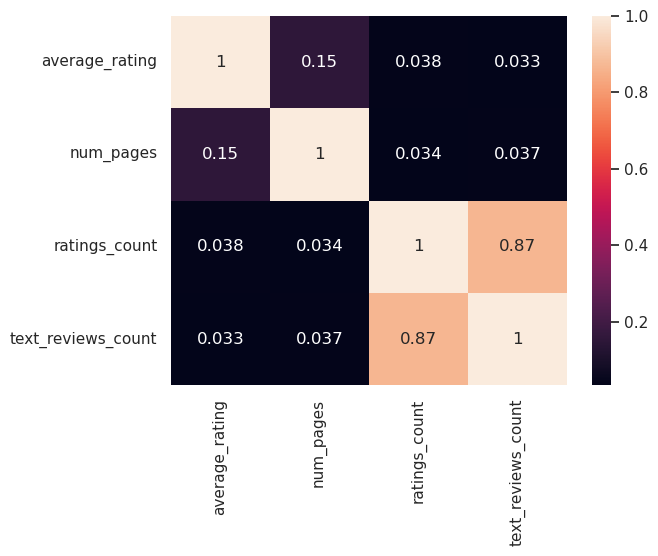

In [7]:
sns.heatmap(df_numerical.corr(), annot=True)

### 1 Languages

In [8]:
df_categorical = df_formatted.select_dtypes(include=["object","string","category"])
display(df_categorical.describe())
print("********Languages Code********")
df_formatted["language_code"].value_counts()

,bookID,title,authors,language_code,publication_date,publisher
count,11072,11072,11072,11072,11072,11072
unique,11072,10301,6625,25,3671,2283
top,1,The Brothers Karamazov,P.G. Wodehouse,eng,10/1/2005,Vintage
freq,1,9,40,10266,56,318


********Languages Code********


eng      10266
spa        218
en-GB      214
fre        144
ger         99
jpn         46
mul         19
zho         14
grc         11
por         10
en-CA        7
ita          5
lat          3
enm          3
rus          2
swe          2
gla          1
wel          1
tur          1
nl           1
nor          1
glg          1
msa          1
ara          1
ale          1
Name: language_code, dtype: int64

To answer __question 2__ "How books in other languages are rated?", we treat repeated characters and we make a graphical visualization of the relation between languages and ratings.

In [9]:
df_formatted["language_code"] = df_formatted["language_code"].replace(to_replace=["en-GB", "en-CA"], value="eng")
df_formatted.head()

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry Potter #6),J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Harry Potter #5),J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry Potter #2),J.K. Rowling,4.42,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harry Potter #3),J.K. Rowling/Mary GrandPré,4.56,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potter #1-5),J.K. Rowling/Mary GrandPré,4.78,eng,2690,41428,164,9/13/2004,Scholastic


<Axes: xlabel='average_rating', ylabel='language_code'>

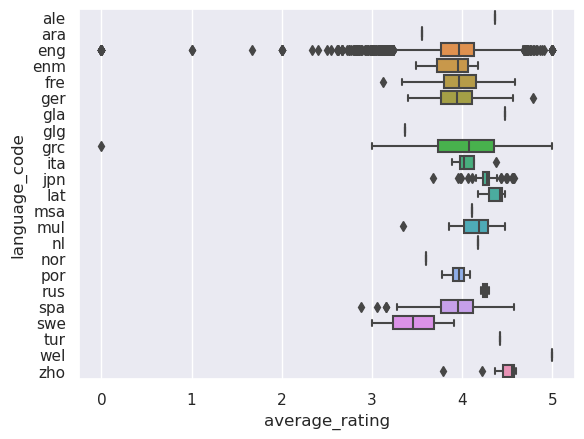

In [10]:
sns.boxplot(data = df_formatted, x = "average_rating", y= "language_code")

#### 1.1 Data transformation of the language code

In [11]:
print(f'Quantity of languages different from ENG, SPA and FRE:{((df_formatted["language_code"].str.lower()!="eng")&(df_formatted["language_code"].str.lower()!="spa")&(df_formatted["language_code"].str.lower()!="fre")).sum()}')
df_formatted["language_code"] = df_formatted["language_code"].map(lambda x: x.lower() if x.lower() in ["eng", "spa", "fre"] else "other")

Quantity of languages different from ENG, SPA and FRE:223


### 2 Publisher

In [17]:
pd.set_option('display.max_rows', None)
df_formatted["publisher"].value_counts().head(30)

Vintage                         318
Penguin Books                   261
Penguin Classics                184
Mariner Books                   150
Ballantine Books                144
HarperCollins                   112
Pocket Books                    111
Harper Perennial                111
Bantam                          110
VIZ Media LLC                    88
Berkley                          86
Dover Publications               85
Modern Library                   81
Del Rey                          80
Tor Books                        76
Oxford University Press  USA     75
Scribner                         73
Oxford University Press          72
Grand Central Publishing         72
W. W. Norton  Company            68
Signet                           66
Cambridge University Press       66
Simon  Schuster                  65
Anchor                           62
Penguin                          58
William Morrow Paperbacks        58
Scholastic Paperbacks            56
Avon                        

To answer __question 3__ "3. Does the publisher impact the ratings?", we first do some data cleaning.
Others ideas to treat the publisher would be:
* replace Ltd by Limited
* remove Inc. or Inc

In [13]:
print(f'Rows of publisher that contains "&"s: {df_formatted["publisher"].str.contains("&", regex=True).sum()}, "and"s: {df_formatted["publisher"].str.contains("and", regex=True).sum()}')
print(f'Original publisher unique values: {df_formatted["publisher"].value_counts().size}')

df_formatted["publisher"] = df_formatted.replace({"publisher":"&"}, "and", regex=True)["publisher"]
print(f'Post-treated publisher unique values: {df_formatted["publisher"].value_counts().size} \n')

#print(f'Rows of publisher that contains "Ltd": {df_formatted["publisher"].str.contains("Ltd", regex=True).sum()}, "Ltd.": {df_formatted["publisher"].str.contains("Ltd.", regex=False).sum()}')

Rows of publisher that contains "&"s: 325, "and"s: 482
Original publisher unique values: 2283
Post-treated publisher unique values: 2271 



### 3 Authors

In [14]:
df_formatted[["authors"]].head()

,authors
0,J.K. Rowling/Mary GrandPré
1,J.K. Rowling/Mary GrandPré
2,J.K. Rowling
3,J.K. Rowling/Mary GrandPré
4,J.K. Rowling/Mary GrandPré


The quantity of authors per book can be a good feature to be evaluated:

In [15]:
df_formatted["number_of_authors"] = df_formatted["authors"].str.split("/").apply(lambda x: len(x))

The simplest idea for a first iteration is to keep only the first author of the column:

In [16]:
df_formatted["authors"] = df_formatted["authors"].str.split(pat="/",n=1, expand= True)[0]
df_formatted["authors"].value_counts().head()

William Shakespeare    88
Stephen King           81
J.R.R. Tolkien         51
P.G. Wodehouse         46
Agatha Christie        44
Name: authors, dtype: Int64

### 4 Publication date

To answer __question 4__ "Does books published long ago are better rated than recently published ones?", we do a feature transformation, converting the data to year, then converting it to ranges from a quartile.

In [16]:
# Forcing the correction, but a function would be better for this
df_formatted.loc[8180, "publication_date"] = "11/30/2000"
df_formatted.loc[11098, "publication_date"] = "6/30/1982"  

In [17]:
%timeit df_formatted["publication_date_datetime"] = df_formatted["publication_date"].apply(lambda x: pd.to_datetime(x, format = '%m/%d/%Y', errors = 'coerce'))

today = pd.to_datetime('today').normalize()
print("Today date:", today)

1.08 s ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Today date: 2023-08-14 00:00:00


If there are dates not written in a good format, they'll appear below:

In [18]:
df_formatted.loc[df_formatted["publication_date_datetime"].isna()]

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,number_of_authors,publication_date_datetime


In [19]:
df_formatted["book_age"] = df_formatted["publication_date_datetime"].apply(lambda x:- (x.year - today.year))

In [20]:
df_formatted["book_age"].describe()

count    11072.000000
mean        22.846098
std          8.261279
min          3.000000
25%         18.000000
50%         20.000000
75%         25.000000
max        123.000000
Name: book_age, dtype: float64

<Axes: xlabel='year', ylabel='average_rating'>

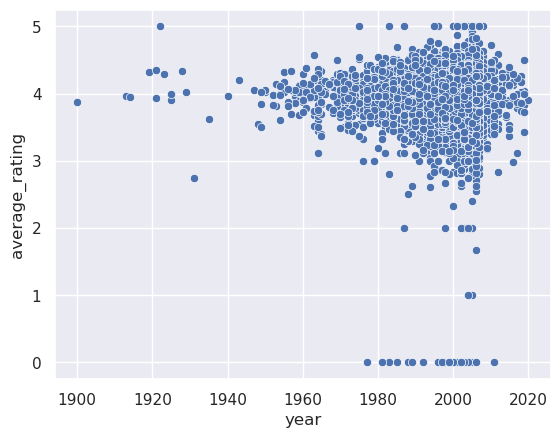

In [21]:
df_formatted["year"] = df_formatted["publication_date_datetime"].dt.year
sns.scatterplot(data = df_formatted, x ="year", y ="average_rating")

Data transformation of the feature year into quartiles. The first one comprehends more recent years.

In [22]:
df_formatted["years_ago"] = pd.qcut(df_formatted["year"],4, labels = [4,3,2,1])

### 5 Title

Maybe the quantity of words in a book name may have an importance on its rating:

In [23]:
df_formatted["number_of_words"] = df_formatted["title"].apply(lambda x: len(x.split(" ")))
df_formatted[["title","number_of_words"]].head()

,title,number_of_words
0,Harry Potter and the Half-Blood Prince (Harry Potter #6),10
1,Harry Potter and the Order of the Phoenix (Harry Potter #5),12
2,Harry Potter and the Chamber of Secrets (Harry Potter #2),11
3,Harry Potter and the Prisoner of Azkaban (Harry Potter #3),11
4,Harry Potter Boxed Set Books 1-5 (Harry Potter #1-5),11


In [24]:
print(f"Quantity of books that belong to a series: {df_formatted['title'].str.contains('#').sum()}")
print("Corresponding to {}% of the dataset".format(round(100*df_formatted['title'].str.contains('#').sum()/df_formatted.shape[0]),1))

Quantity of books that belong to a series: 2337
Corresponding to 21% of the dataset


A feature that tells us if the book belongs to a series of book or not.
From the boxplot we can conclude that the median of books series is higher. However, its distribution its 4th quartile range has lower maximum average rating.

<Axes: xlabel='if_series', ylabel='average_rating'>

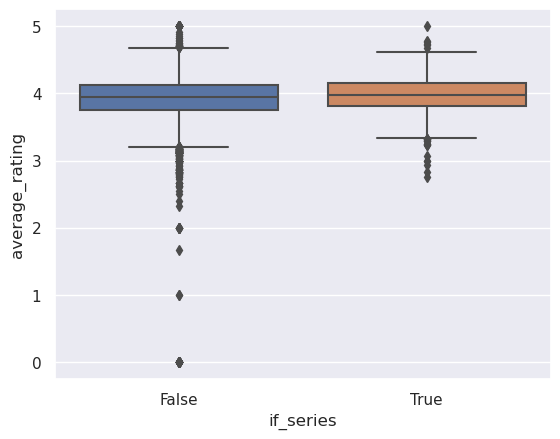

In [25]:
df_formatted['if_series'] = df_formatted['title'].str.contains('#') #include the parethesis
sns.boxplot(data = df_formatted, x ="if_series", y ="average_rating")

/tmp/ipykernel_42107/2998510005.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_formatted.corr(), annot = True, fmt=".1f")


<Axes: >

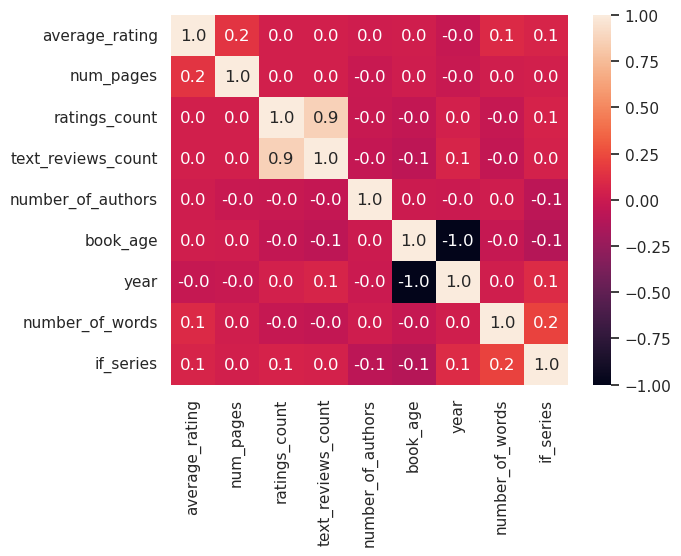

In [26]:
sns.heatmap(df_formatted.corr(), annot = True, fmt=".1f")

# Model selection

In [31]:
df_1 = df_formatted.set_index("bookID").drop(columns = ["text_reviews_count", "years_ago","publication_date", "publication_date_datetime", "year", "title"])
df_1.head() #"ratings_count", 

,authors,average_rating,language_code,num_pages,ratings_count,publisher,number_of_authors,book_age,number_of_words,if_series
bookID,,,,,,,,,,
1,J.K. Rowling,4.57,eng,652,2095690,Scholastic Inc.,2,17,10,True
2,J.K. Rowling,4.49,eng,870,2153167,Scholastic Inc.,2,19,12,True
4,J.K. Rowling,4.42,eng,352,6333,Scholastic,1,20,11,True
5,J.K. Rowling,4.56,eng,435,2339585,Scholastic Inc.,2,19,11,True
8,J.K. Rowling,4.78,eng,2690,41428,Scholastic,2,19,11,True


In [32]:
y = df_1[["average_rating"]]
X = df_1.drop("average_rating", axis = 1)
X.head()

,authors,language_code,num_pages,ratings_count,publisher,number_of_authors,book_age,number_of_words,if_series
bookID,,,,,,,,,
1,J.K. Rowling,eng,652,2095690,Scholastic Inc.,2,17,10,True
2,J.K. Rowling,eng,870,2153167,Scholastic Inc.,2,19,12,True
4,J.K. Rowling,eng,352,6333,Scholastic,1,20,11,True
5,J.K. Rowling,eng,435,2339585,Scholastic Inc.,2,19,11,True
8,J.K. Rowling,eng,2690,41428,Scholastic,2,19,11,True


For this second iteration:  
We keep the structure of pipeline with cross_validate. But for the evaluation of the results, we keep it simple only printing the metrics.

In [33]:
metrics_list = ['neg_mean_absolute_error','neg_mean_squared_error','r2']

# the parameter handle_unknown stands for when 
preprocessor = ColumnTransformer([("author", OrdinalEncoder(handle_unknown= "use_encoded_value", unknown_value = -1), ["authors"]),
                                  ("lang", OneHotEncoder(), ["language_code"]),
                                  ("publisher", OrdinalEncoder(handle_unknown= "use_encoded_value", unknown_value = -1), ["publisher"]),
                                  ("series", OrdinalEncoder(), ["if_series"])
                                  ], remainder='passthrough') # remainder allows columns not declared on the ColumnTransformer not to be dropped and
                                  # passthrough it for the next step of the pipeline


#models = [LinearRegression(), DecisionTreeRegressor(), GradientBoostingRegressor()]
models = [LinearRegression(), DecisionTreeRegressor(max_depth=2)]
for model in models:

    model = Pipeline([("preprocessor",preprocessor),("model", model)])
    results = cross_validate(model, X, y, cv = 3,scoring = metrics_list, return_train_score=False, error_score='raise')

    for key, value in results.items():
        print(f'''
        {key} train: {value.tolist()[0]}
         {key} test: {value.tolist()[1]}
         {key} valid: {value.tolist()[2]} \n''')
# We see that both linear regression and decision tree present metrics close to each other for the validation dataset.
# The mean absolute error (MAE) is around +- 0.23 for the ratings (e.g. value predicted +- 0.23 of error)
# The R2 is very low around 0.02, while the closer to 1, the best the fit.
# So the results are not so good.


        fit_time train: 0.029077768325805664
         fit_time test: 0.029703617095947266
         fit_time valid: 0.03260540962219238 


        score_time train: 0.021455764770507812
         score_time test: 0.01942586898803711
         score_time valid: 0.015885591506958008 


        test_neg_mean_absolute_error train: -0.21895696683545565
         test_neg_mean_absolute_error test: -0.2333855939313177
         test_neg_mean_absolute_error valid: -0.23305311591018357 


        test_neg_mean_squared_error train: -0.10181887034731896
         test_neg_mean_squared_error test: -0.12472390400342885
         test_neg_mean_squared_error valid: -0.13003760178209117 


        test_r2 train: 0.051879026179405874
         test_r2 test: 0.02542835990316039
         test_r2 valid: 0.023895862725764272 


        fit_time train: 0.030927419662475586
         fit_time test: 0.04592752456665039
         fit_time valid: 0.03520822525024414 


        score_time train: 0.01593184471130371
     